In [1]:
import cv2
import glob
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda, ELU, Activation
from keras.layers.convolutional import Convolution2D
from keras.optimizers import Adam
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd


%matplotlib inline

Using TensorFlow backend.


In [2]:
SIMULATOR_HOME = "/Users/ddigges/simulator/data/"
DRIVING_LOG_FILE = "driving_log.csv"
DRIVING_LOG_FILE_PATH = os.path.join(SIMULATOR_HOME, DRIVING_LOG_FILE)

IMG = "IMG"
IMAGE_PATH = os.path.join(os.path.join(SIMULATOR_HOME, IMG))

n = len(glob.glob(os.path.join(IMAGE_PATH, "*"))) * 3
batch_size = 128
samples_per_epoch = int(n/batch_size)
nb_epoch = 10
steering_offset = 0.25
num_channels = 1

In [3]:
driving_log = pd.read_csv(DRIVING_LOG_FILE_PATH)

In [4]:
driving_log.columns = ["center", "left", "right", "steering", "throttle", "brake", "speed"]

In [5]:
driving_log.head()

,center,left,right,steering,throttle,brake,speed
0,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg,0.0,0.0,0.0,22.148290
1,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg,0.0,0.0,0.0,21.879630
2,IMG/center_2016_12_01_13_31_12_937.jpg,IMG/left_2016_12_01_13_31_12_937.jpg,IMG/right_2016_12_01_13_31_12_937.jpg,0.0,0.0,0.0,1.453011
3,IMG/center_2016_12_01_13_31_13_037.jpg,IMG/left_2016_12_01_13_31_13_037.jpg,IMG/right_2016_12_01_13_31_13_037.jpg,0.0,0.0,0.0,1.438419
4,IMG/center_2016_12_01_13_31_13_177.jpg,IMG/left_2016_12_01_13_31_13_177.jpg,IMG/right_2016_12_01_13_31_13_177.jpg,0.0,0.0,0.0,1.418236


In [6]:
driving_log["center"], driving_log["steering"]

(0       IMG/center_2016_12_01_13_30_48_287.jpg
 1       IMG/center_2016_12_01_13_30_48_404.jpg
 2       IMG/center_2016_12_01_13_31_12_937.jpg
 3       IMG/center_2016_12_01_13_31_13_037.jpg
 4       IMG/center_2016_12_01_13_31_13_177.jpg
 5       IMG/center_2016_12_01_13_31_13_279.jpg
 6       IMG/center_2016_12_01_13_31_13_381.jpg
 7       IMG/center_2016_12_01_13_31_13_482.jpg
 8       IMG/center_2016_12_01_13_31_13_584.jpg
 9       IMG/center_2016_12_01_13_31_13_686.jpg
 10      IMG/center_2016_12_01_13_31_13_786.jpg
 11      IMG/center_2016_12_01_13_31_13_890.jpg
 12      IMG/center_2016_12_01_13_31_13_991.jpg
 13      IMG/center_2016_12_01_13_31_14_092.jpg
 14      IMG/center_2016_12_01_13_31_14_194.jpg
 15      IMG/center_2016_12_01_13_31_14_295.jpg
 16      IMG/center_2016_12_01_13_31_14_398.jpg
 17      IMG/center_2016_12_01_13_31_14_500.jpg
 18      IMG/center_2016_12_01_13_31_14_602.jpg
 19      IMG/center_2016_12_01_13_31_14_702.jpg
 20      IMG/center_2016_12_01_13_31_14_

In [7]:
image = cv2.cvtColor(plt.imread(os.path.join(SIMULATOR_HOME, driving_log[:1]['center'][0])), cv2.COLOR_BGR2YUV)

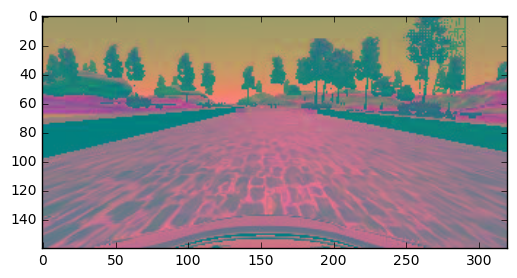

In [8]:
plt.imshow(image)

In [9]:
rows_to_crop_top = int(image.shape[0] * 0.3)
rows_to_crop_bottom = int(image.shape[0] * 0.1)

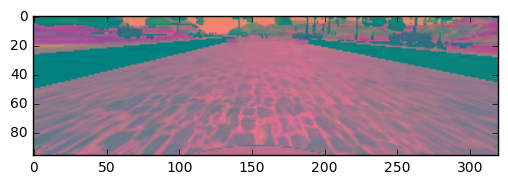

In [10]:
image = image[rows_to_crop_top:image.shape[0] - rows_to_crop_bottom, :, :]
plt.imshow(image)

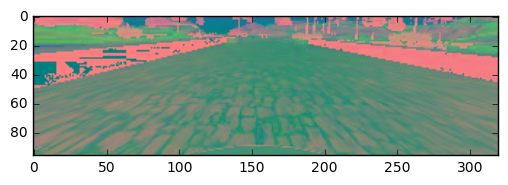

In [11]:
row,col,ch= image.shape
mean = 0
sigma = 0.0000001
gauss = np.random.normal(mean,sigma,(row,col,ch))
noisy = image + gauss
plt.imshow(noisy)

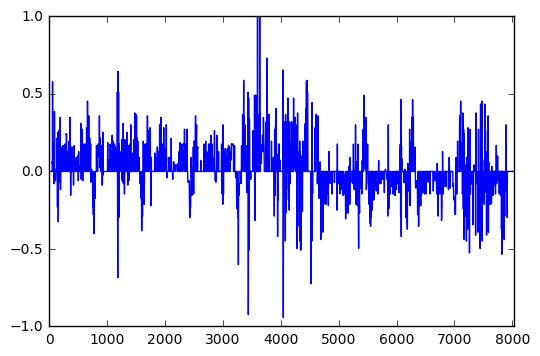

In [12]:
driving_log.steering.plot.line();

In [13]:
def read_image(file_name):
    return plt.imread(file_name)

In [14]:
val = driving_log[:1]['center']

In [15]:
image = read_image(os.path.join(SIMULATOR_HOME, val.values[0]))

In [16]:
# IMAGE: 160 x 320 with 3 color channels
image.shape

(160, 320, 3)

In [20]:
def pre_process(image):
    """
        image: input image
        
        - convert to grayscale
        - resize image to half it's original size
    """
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    image = np.mean(image, axis=2)
    
    data_min = np.min(image)
    data_max = np.max(image)
    b = 0.5
    a = -0.5
    image = ((b-a) * (image - data_min)/(data_max - data_min)) + a
    
    rows_to_crop_top = int(image.shape[0] * 0.3)
    rows_to_crop_bottom = int(image.shape[0] * 0.1)
    image = image[rows_to_crop_top:image.shape[0] - rows_to_crop_bottom, :]    
    
    row,col= image.shape
    gauss = np.random.normal(mean,sigma,(row,col))
    image = image + gauss
    
    return cv2.resize(image, (0,0), fx=0.5, fy=0.5) 

def flatten(image):
    return image.reshape((image.shape[0], image.shape[1], num_channels))

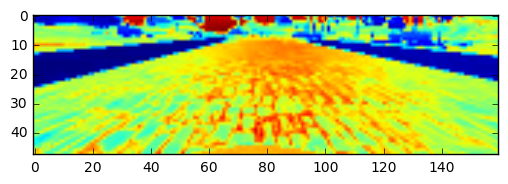

In [21]:
image = plt.imread(os.path.join(SIMULATOR_HOME, driving_log[:200]['center'][0]))
plt.imshow(pre_process(image))

In [22]:
for i, row in driving_log[:3].iterrows():
    print(row['center'], row['steering'])

IMG/center_2016_12_01_13_30_48_287.jpg 0.0
IMG/center_2016_12_01_13_30_48_404.jpg 0.0
IMG/center_2016_12_01_13_31_12_937.jpg 0.0


In [23]:
# shuffle
driving_log = driving_log.sample(frac=1).reset_index(drop=True)

In [24]:
driving_log.shape

(8036, 7)

In [25]:
def data_generator(df, batch_size=128):
    n_rows = df.shape[0]
    while True:
        # Shuffle the data frame rpws after every complete cycle through the data
        df = df.sample(frac=1).reset_index(drop=True)
        
        for index in range(0, n_rows, batch_size):
            df_batch = df[index: index + batch_size]

            # Ignoring the last batch which is smaller than the requested batch size
            if(df_batch.shape[0] == batch_size):
                
                for image_type in ["center"]: #, "left", "right"]:
                    X_batch = np.array([flatten(pre_process(mpimg.imread(os.path.join(SIMULATOR_HOME, row[image_type].strip())))) for i, row in df_batch.iterrows()])
                    if(image_type == "center"):
                        y_batch = np.array([row['steering'] for i, row in df_batch.iterrows()])
                    elif(image_type == "left"):
                        y_batch = np.array([row['steering'] + steering_offset  for i, row in df_batch.iterrows()])
                    elif(image_type == "right"):
                        y_batch = np.array([row['steering'] - steering_offset  for i, row in df_batch.iterrows()])
                    yield X_batch, y_batch


In [26]:
gen = data_generator(driving_log)

In [27]:
X_batch, y_batch = next(gen)

In [28]:
X_batch.shape

(128, 48, 160, 1)

In [29]:
y_batch.shape

(128,)

(array([  3.,   3.,   7.,  13.,  71.,  12.,  10.,   4.,   3.,   2.]),
 array([-0.373071  , -0.28844322, -0.20381544, -0.11918766, -0.03455988,
         0.0500679 ,  0.13469568,  0.21932346,  0.30395124,  0.38857902,
         0.4732068 ]),
 <a list of 10 Patch objects>)

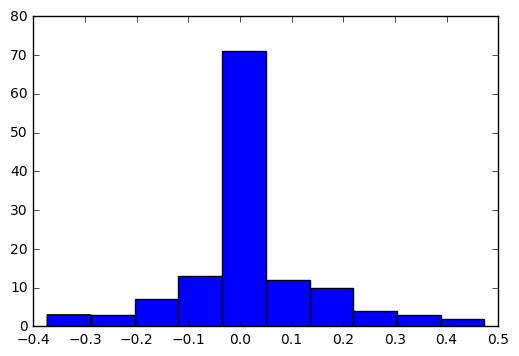

In [30]:
plt.hist(y_batch)

In [31]:
gen = data_generator(driving_log)

x,y = next(gen)
x.shape

gen = data_generator(driving_log)
print(x.shape[1], x.
      shape[2], 1)

48 160 1


In [32]:
model = Sequential()

model.add(Convolution2D(24, 5, 5, subsample=(2, 2), border_mode="same", input_shape=(x.shape[1], x.shape[2], num_channels)))
model.add(ELU())
model.add(Convolution2D(36, 5, 5, subsample=(2, 2), border_mode="same"))
model.add(ELU())
model.add(Convolution2D(48, 5, 5, subsample=(2, 2), border_mode="same"))
model.add(ELU())
model.add(Convolution2D(64, 3, 3, subsample=(1, 1), border_mode="same"))
model.add(ELU())
model.add(Convolution2D(64, 3, 3, subsample=(1, 1), border_mode="same"))
model.add(Flatten())
model.add(Dropout(.4))
model.add(ELU())
model.add(Dense(100))
model.add(Dropout(.4))
model.add(ELU())
model.add(Dense(50))
model.add(Dropout(.4))
model.add(ELU())
model.add(Dense(1))

adam = Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(optimizer=adam, loss="mse")


In [33]:
model.fit_generator(gen, samples_per_epoch*batch_size, nb_epoch=1)

Epoch 1/1
72320/72320 [==============================] - 819s - loss: 0.0136   


In [34]:
model.save_weights("model.h5")

In [35]:
file = open("model.json", "w")
file.write(model.to_json())
file.close()